# Data

## Download data

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gpiosenka/70-dog-breedsimage-data-set")

print("Path to dataset files:", path)

: 

## load data

In [2]:
import pandas as pd
import os

In [19]:
dog_train ='/kaggle/input/70-dog-breedsimage-data-set/train'
dog_valid ='/kaggle/input/70-dog-breedsimage-data-set/valid'

In [20]:
def make_dataframe(data_dir):
    filepaths = []
    labels = []

    for label in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, label)
        if os.path.isdir(class_dir):
            for file in os.listdir(class_dir):
                filepaths.append(os.path.join(class_dir, file))
                labels.append(label)

    return pd.DataFrame({'filename': filepaths, 'class': labels})

In [21]:
train_df = make_dataframe(dog_train)
valid_df = make_dataframe(dog_valid)

In [22]:
train_df.head(400)

## Augmentation data

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    fill_mode='nearest'
)

In [24]:
datagen_valid = ImageDataGenerator(rescale=1./255)

In [ ]:
train_gen = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=(224,224),
    batch_size = 50,
    class_mode='categorical',
    shuffle=True
    )

In [ ]:
val_gen = datagen_valid.flow_from_dataframe(
    dataframe =valid_df,
    x_col='filename',
    y_col='class',
    target_size=(224,224),
    batch_size = 50,
    class_mode='categorical',
    shuffle=False
)



# Model




## ResNet

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam


# new layers , output layer

In [ ]:
# Load pre-trained EfficientNetB0 without الـ top
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model to save time
for layer in base_model.layers[-4:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)   
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)               
predictions = Dense(70, activation='softmax')(x)  


model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
model.summary()

In [ ]:
history = model.fit(train_gen,epochs=5,validation_data=val_gen)

In [ ]:
model.save('dog_project.keras')


In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.savefig("images/accuracy.png")
plt.show()

# Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.savefig("images/loss.png")
plt.show()


44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 182ms/step


NameError: name 'plt' is not defined

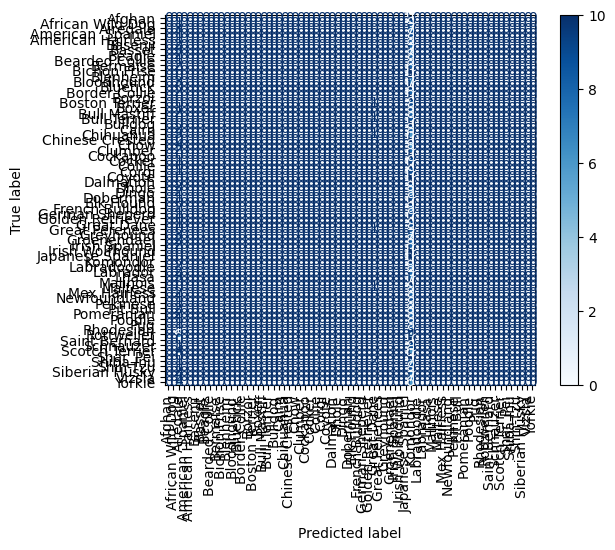

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
test_generator = val_gen
y_true = test_generator.classes   # لو بتستخدمي ImageDataGenerator
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices)
disp.plot(cmap="Blues", xticks_rotation=90)
plt.title("Confusion Matrix")
plt.savefig("images/confusion_matrix.png")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = "dataset/test/golden_retriever/img1.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
pred_class = np.argmax(prediction)

plt.imshow(image.load_img(img_path))
plt.title(f"Predicted: {list(train_gen.class_indices.keys())[pred_class]}")
plt.savefig("images/prediction.png")
plt.show()


# Deployment

In [ ]:
model.save('dog_project.keras')


In [ ]:
import tensorflow as tf
temp = tf.keras.models.load_model('dog_project.keras')

In [ ]:
temp.evaluate(val_gen)

In [ ]:
temp.summary()